C:\ProgramData\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.01995 | valid_accuracy: 0.76779 | test_accuracy: 0.79851 |  0:00:00s
epoch 1  | loss: 0.552   | valid_accuracy: 0.79026 | test_accuracy: 0.85075 |  0:00:01s
epoch 2  | loss: 0.47426 | valid_accuracy: 0.84644 | test_accuracy: 0.89552 |  0:00:02s
epoch 3  | loss: 0.39601 | valid_accuracy: 0.87266 | test_accuracy: 0.90299 |  0:00:03s
epoch 4  | loss: 0.35854 | valid_accuracy: 0.89139 | test_accuracy: 0.90672 |  0:00:04s
epoch 5  | loss: 0.33737 | valid_accuracy: 0.8839  | test_accuracy: 0.89179 |  0:00:04s
epoch 6  | loss: 0.3051  | valid_accuracy: 0.8839  | test_accuracy: 0.90672 |  0:00:05s
epoch 7  | loss: 0.30986 | valid_accuracy: 0.88764 | test_accuracy: 0.91045 |  0:00:06s
epoch 8  | loss: 0.26933 | valid_accuracy: 0.89888 | test_accuracy: 0.90672 |  0:00:07s
epoch 9  | loss: 0.25516 | valid_accuracy: 0.88764 | test_accuracy: 0.91791 |  0:00:07s
epoch 10 | loss: 0.24152 | valid_accuracy: 0.88015 | test_accuracy: 0.88806 |  0:00:08s
epoch 11 | loss: 0.23408 | valid

C:\ProgramData\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



[Validation set results]
Accuracy: 0.9101123595505618
Precision: 0.910639583417816
Recall: 0.9101123595505618
F1 Score: 0.9102133835667255
AUC Score: 0.9699714128060787
Log Loss: 0.2830035514610323

Classification Report:
               precision    recall  f1-score   support

        High       0.94      0.92      0.93       154
         Low       0.91      0.97      0.94        33
      Medium       0.85      0.86      0.86        80

    accuracy                           0.91       267
   macro avg       0.90      0.92      0.91       267
weighted avg       0.91      0.91      0.91       267


[Test set results]
Accuracy: 0.9477611940298507
Precision: 0.9491915422885572
Recall: 0.9477611940298507
F1 Score: 0.9470965825084752
AUC Score: 0.9800770648080032
Log Loss: 0.23125885011929165

Classification Report:
               precision    recall  f1-score   support

        High       0.95      0.99      0.97       154
         Low       0.89      0.97      0.93        33
      Medium

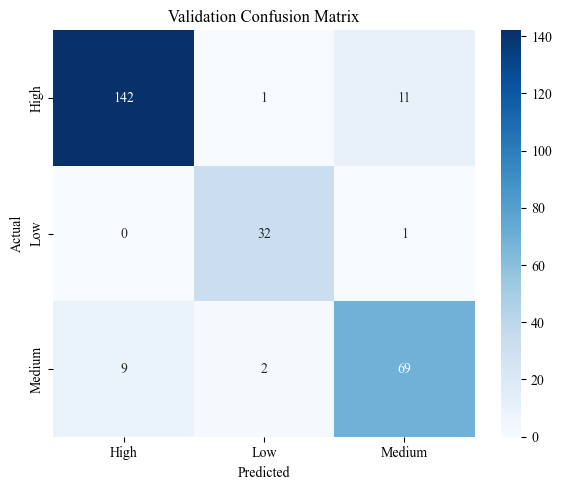

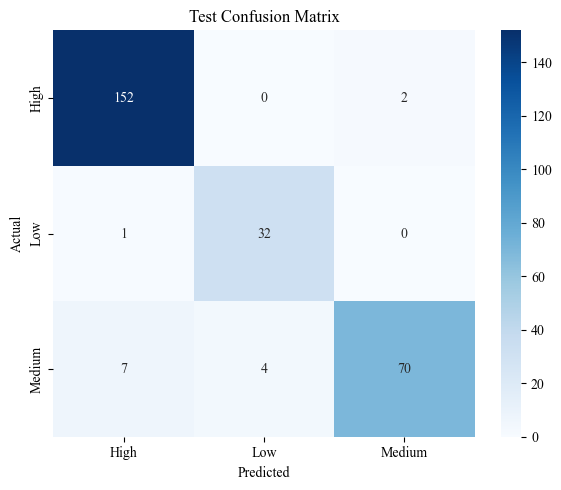

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss
from pytorch_tabnet.tab_model import TabNetClassifier
import torch
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

df = pd.read_excel("key descriptor.xlsx")
X = df.drop(columns=["name", "Risk_Level"])
y = df["Risk_Level"]

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_binarized = label_binarize(y_encoded, classes=[0, 1, 2])

X_train, X_temp, y_train, y_temp = train_test_split(
    X.values, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train).astype(np.float32)
X_valid = scaler.transform(X_valid).astype(np.float32)
X_test = scaler.transform(X_test).astype(np.float32)

best_params = {
    'n_d': 60,
    'n_a': 59,
    'n_steps': 3,
    'gamma': 1.2733688998932382,
    'lambda_sparse': 5.2798545728611394e-05,
    'momentum': 0.2288187711682802,
    'lr': 0.009719886970798132
}

lr = best_params.pop("lr")
best_params["optimizer_params"] = {"lr": lr}

clf = TabNetClassifier(**best_params, seed=42)

clf.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid), (X_test, y_test)],
    eval_name=["valid", "test"],
    eval_metric=["accuracy"],
    max_epochs=100,
    patience=20,
    batch_size=256,
    virtual_batch_size=128,
)

def evaluate_and_print(X_data, y_data, dataset_name):
    y_pred = clf.predict(X_data)
    y_proba = clf.predict_proba(X_data)
    y_bin = label_binarize(y_data, classes=[0, 1, 2])

    print(f"\n[{dataset_name} set results]")
    print("Accuracy:", accuracy_score(y_data, y_pred))
    print("Precision:", precision_score(y_data, y_pred, average='weighted'))
    print("Recall:", recall_score(y_data, y_pred, average='weighted'))
    print("F1 Score:", f1_score(y_data, y_pred, average='weighted'))
    print("AUC Score:", roc_auc_score(y_bin, y_proba, multi_class='ovr', average='weighted'))
    print("Log Loss:", log_loss(y_data, y_proba))
    print("\nClassification Report:\n", classification_report(y_data, y_pred, target_names=label_encoder.classes_))

evaluate_and_print(X_valid, y_valid, "Validation")
evaluate_and_print(X_test, y_test, "Test")

def plot_confusion_matrix(X_data, y_data, dataset_name, filename):
    y_pred = clf.predict(X_data)
    cm = confusion_matrix(y_data, y_pred)

    plt.rcParams['font.family'] = 'Times New Roman'
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues",
        xticklabels=label_encoder.classes_, 
        yticklabels=label_encoder.classes_
    )
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{dataset_name} Confusion Matrix")
    plt.tight_layout()
    plt.savefig(filename, dpi=600, bbox_inches='tight')
    plt.show()

plot_confusion_matrix(X_valid, y_valid, "Validation", "Confusion_Matrix_Validation.png")
plot_confusion_matrix(X_test, y_test, "Test", "Confusion_Matrix_Test.png")

All features:
CrippenLogP: 0.1621
nAcid: 0.1062
SCH-7: 0.0764
BCUTp-1h: 0.0760
maxHBa: 0.0714
MATS1s: 0.0702
minsF: 0.0651
VE1_Dzv: 0.0596
ALogP: 0.0409
minaasC: 0.0333
GATS4i: 0.0307
AATSC6v: 0.0302
VE1_Dzs: 0.0301
SpMax3_Bhs: 0.0282
VE3_Dzs: 0.0204
AATSC2m: 0.0188
minHBd: 0.0184
VR1_Dzp: 0.0111
ETA_Beta_ns_d: 0.0101
MATS6i: 0.0099
minsOH: 0.0097
VR1_D: 0.0090
ALogp2: 0.0069
ATSC1s: 0.0034
SpMin5_Bhs: 0.0015
ATSC6i: 0.0006


C:\Users\xu\AppData\Local\Temp\ipykernel_35424\2873359457.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


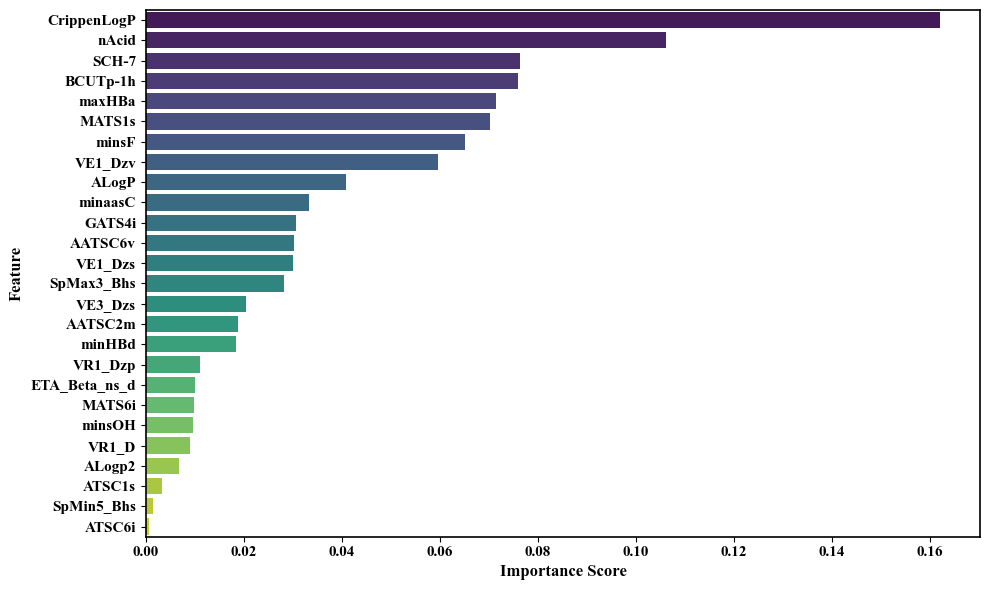

In [3]:
importances = clf.feature_importances_
feat_names = X.columns
topk = np.argsort(importances)[::-1]

print("All features:")
for i in topk:
    print(f"{feat_names[i]}: {importances[i]:.4f}")

plt.rcParams['font.family'] = 'Times New Roman'
plt.figure(figsize=(10, 6))

sorted_idx = np.argsort(importances)[::-1]
sns.barplot(
    x=importances[sorted_idx],
    y=feat_names[sorted_idx],
    palette="viridis",
)

ax = plt.gca()
ax.tick_params(axis='both', labelsize=11)
for label in ax.get_yticklabels():
    label.set_fontweight('bold')
for label in ax.get_xticklabels():
    label.set_fontweight('bold')

for spine in ax.spines.values():
    spine.set_linewidth(1.2)

plt.xlabel("Importance Score", fontsize=12, fontweight='bold')
plt.ylabel("Feature", fontsize=12, fontweight='bold')
plt.title("", fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig("Feature_Importances1.png", dpi=600, bbox_inches='tight')
plt.show()

In [4]:
import shap

explainer = shap.Explainer(clf.predict_proba, X_train)

shap_values = explainer(X_test)

PermutationExplainer explainer: 269it [21:31,  4.82s/it]                                                               


In [5]:
import matplotlib.pyplot as plt
import numpy as np

C:\Users\xu\AppData\Local\Temp\ipykernel_35424\2596635900.py:8: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


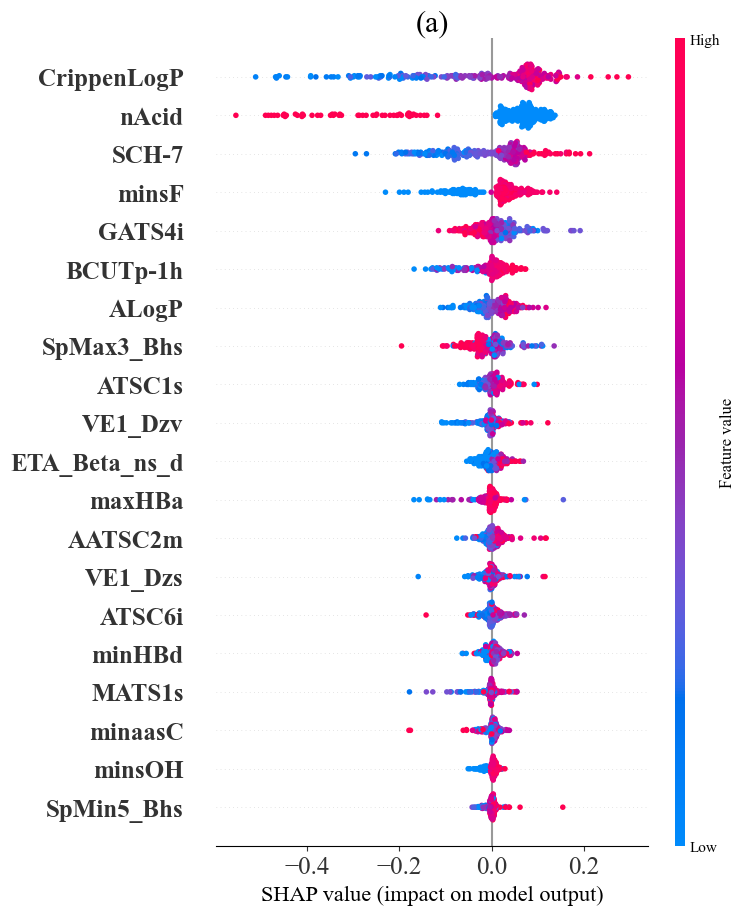

In [6]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 18
plt.figure(figsize=(10, 6))
# shap_values.values.shape = (n_samples, n_features, n_classes)
class_idx = 0
shap.summary_plot(
    shap_values.values[:, :, class_idx], 
    features=X_test,
    feature_names=feat_names,
    show=False
)
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=16)
ax.set_xlabel(ax.get_xlabel(), fontsize=16)
plt.title(f"(c)", fontsize=18)
for label in ax.get_yticklabels():
    label.set_fontweight('bold')
plt.title(f"(a)")
plt.tight_layout()
plt.savefig(f"SHAP_Summary_Class{class_idx}.png", dpi=600, bbox_inches='tight')
plt.show()


C:\Users\xu\AppData\Local\Temp\ipykernel_35424\3218268104.py:8: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


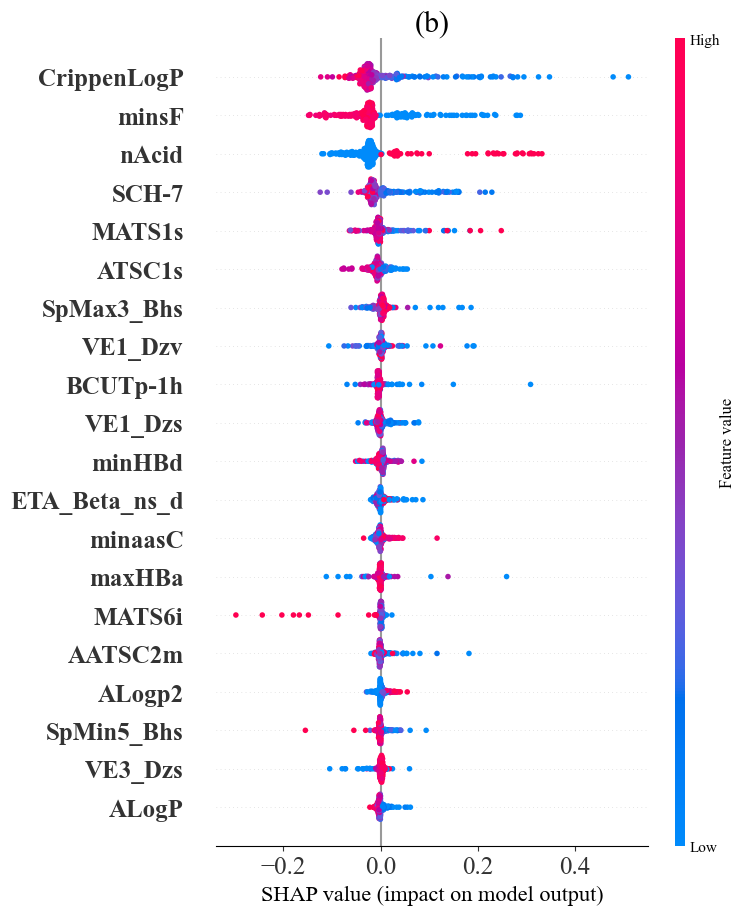

In [7]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 18
plt.figure(figsize=(10, 6))
class_idx = 1
shap.summary_plot(
    shap_values.values[:, :, class_idx],
    features=X_test,
    feature_names=feat_names,
    show=False
)
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=16)
ax.set_xlabel(ax.get_xlabel(), fontsize=16)
plt.title(f"(c)", fontsize=18)
for label in ax.get_yticklabels():
    label.set_fontweight('bold')
plt.title(f"(b)")
plt.tight_layout()
plt.savefig(f"SHAP_Summary_Class{class_idx}.png", dpi=600, bbox_inches='tight')
plt.show()

C:\Users\xu\AppData\Local\Temp\ipykernel_35424\3202330349.py:8: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


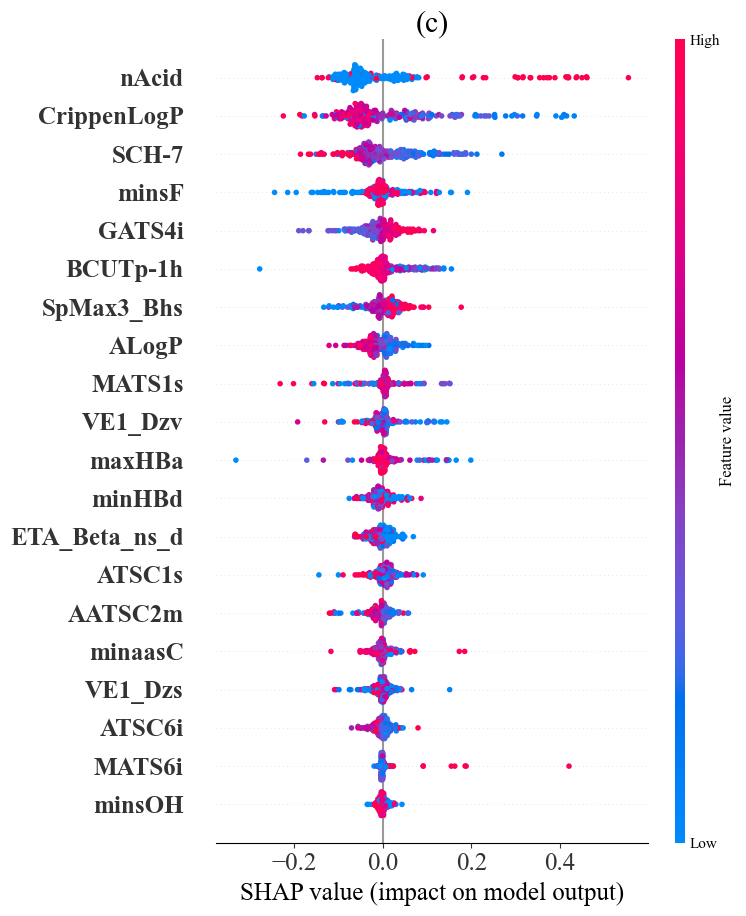

In [8]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 18
plt.figure(figsize=(10, 6))
class_idx = 2
shap.summary_plot(
    shap_values.values[:, :, class_idx],
    features=X_test,
    feature_names=feat_names,
    show=False
)
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=16)
ax.set_xlabel(ax.get_xlabel(), fontsize=18)
plt.title(f"(c)", fontsize=18)
for label in ax.get_yticklabels():
    label.set_fontweight('bold')
plt.title(f"(c)")
plt.tight_layout()
plt.savefig(f"SHAP_Summary_Class{class_idx}.png", dpi=600, bbox_inches='tight')
plt.show()

C:\Users\xu\AppData\Local\Temp\ipykernel_35424\1767524445.py:5: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


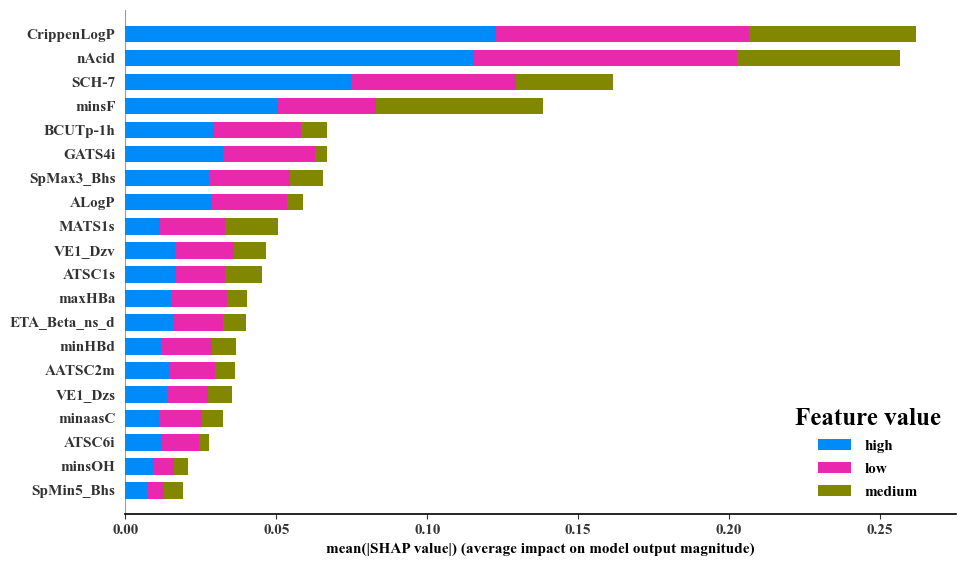

In [9]:
# ===== SHAP Summary Plot =====
plt.rcParams['font.family'] = 'Times New Roman'
plt.figure(figsize=(10, 6))

shap.summary_plot(
    shap_values,
    X_test,
    feature_names=feat_names,
    show=False,
    plot_size=(10, 6),
    alpha=0.8,
    color_bar=True
)

legend = plt.gca().get_legend()
if legend is not None:
    new_labels = ["high", "low", "medium"]
    for text, new_label in zip(legend.get_texts(), new_labels):
        text.set_text(new_label)
    legend.set_title("Feature value")
    legend.get_title().set_fontweight('bold')
    for text in legend.get_texts():
        text.set_fontsize(11)
        text.set_fontweight('bold')

ax = plt.gca()
ax.tick_params(axis='both', labelsize=11)
for label in ax.get_yticklabels():
    label.set_fontweight('bold')
for label in ax.get_xticklabels():
    label.set_fontweight('bold')

for spine in ax.spines.values():
    spine.set_linewidth(1.2)
    
xlabel = ax.get_xlabel()
if xlabel:
    ax.set_xlabel(xlabel, fontweight='bold', fontsize=11)

plt.subplots_adjust(left=0.25, right=0.95, top=0.9, bottom=0.15)

plt.title("", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig("SHAP_Summary1.png", dpi=600, bbox_inches='tight')
plt.show()